In [13]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np
import scipy
import cv2

In [14]:
IMAGE_FILE = '../data/examples/horses.jpg'

BLOCK_SIZE = 8

def BLOCK(x, y, dim = None):
	if dim != None:
		return np.s_[x : x + BLOCK_SIZE, y : y + BLOCK_SIZE, dim]
	return np.s_[x : x + BLOCK_SIZE, y : y + BLOCK_SIZE]

In [15]:
def rgb2ycbcr(im):
	xform = np.array([
		[0.299, 0.587, 0.114], 
		[-0.168736, -0.331264, 0.5], 
		[0.5, -0.418688, -0.081312]
	])
	ycbcr = im.dot(xform.T)
	ycbcr[:,:,[1,2]] += 128
	ycbcr = np.clip(ycbcr, 0, 255)
	return np.uint8(ycbcr)

def ycbcr2rgb(im):
	xform = np.array([
		[1, 0, 1.402], 
		[1, -0.344136, -0.714136], 
		[1, 1.772, 0]
	])
	rgb = im.astype(np.float)
	rgb[:,:,[1,2]] -= 128
	rgb = np.clip(rgb.dot(xform.T), 0, 255)
	return np.uint8(rgb)

9 208.38884286136113 255


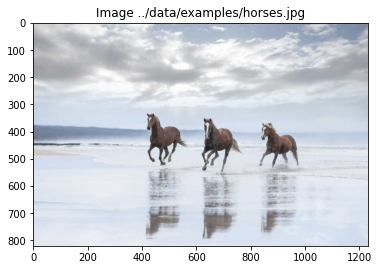

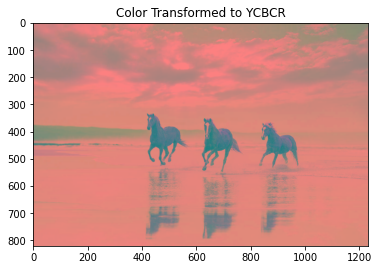

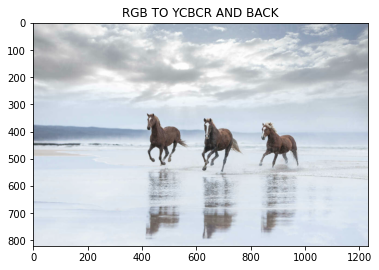

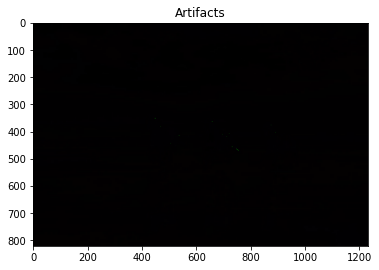

In [17]:

plt.rcParams['figure.figsize'] = [6, 6]

image = imread(IMAGE_FILE)

# ycc = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
ycc = rgb2ycbcr(image)

plt.figure()
plt.title("Image " + IMAGE_FILE)
plt.imshow(image)

plt.figure()
plt.title("Color Transformed to YCBCR")
plt.imshow(ycc)

back = ycbcr2rgb(ycc)
# back = cv2.cvtColor(ycc, cv2.COLOR_YCrCb2BGR)

plt.figure()
plt.title("RGB TO YCBCR AND BACK")
plt.imshow(back)

artifacts = image - back
plt.figure()
plt.title("Artifacts")
plt.imshow(artifacts)



In [ ]:
# TODO: Chroma Subsampling
# https://en.wikipedia.org/wiki/JPEG#downsampling

In [18]:
def pad(value, multiple = BLOCK_SIZE):
	return int(multiple * np.ceil(value / multiple))

def cut(value, multiple = BLOCK_SIZE):
	return int(multiple * np.floor(value / multiple))

print('original:', image.shape)

# Pad only X and Y dimensions of image
imsize = list(image.shape)
imsize[0] = cut(imsize[0])
imsize[1] = cut(imsize[1])
imsize = tuple(imsize)

print('padded:', imsize)

# FIXME: CUTTING ORIGINAL IMAGE
im = np.resize(ycc, imsize)
image = np.resize(image, imsize)
print(im.shape)

# Pad image with 0 on bottom and right borders
# TODO: Pad with repeating values on borders
# im = np.pad(np.array(image), [
# 	(0, imsize[0] - image.shape[0]), 
# 	(0, imsize[1] - image.shape[1]),
# ])


original: (821, 1232, 3)
padded: (816, 1232, 3)
(816, 1232, 3)


In [19]:
def DCT_2D(a):
	return scipy.fftpack.dct(
			scipy.fftpack.dct(a, axis = 0, norm = 'ortho'),
		axis = 1, norm = 'ortho'
	)

def IDCT_2D(a):
    return scipy.fftpack.idct(
			scipy.fftpack.idct(a, axis = 0, norm = 'ortho'),
		axis = 1, norm = 'ortho'
	)


In [20]:

dct = np.zeros(imsize)

# Apply 8x8 block DCT
for i in np.r_[:imsize[0] : BLOCK_SIZE]:
	for j in np.r_[:imsize[1] : BLOCK_SIZE]:
		dct[BLOCK(i, j)] = DCT_2D(im[BLOCK(i, j)].astype(int) - 128)

Text(0.5, 1.0, "8x8 DCT block at position 400 for Y'")

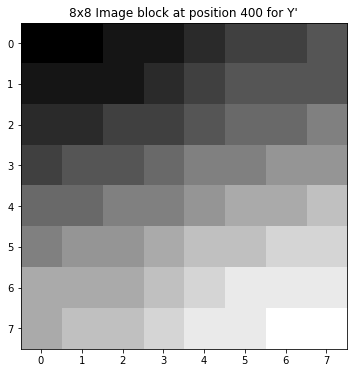

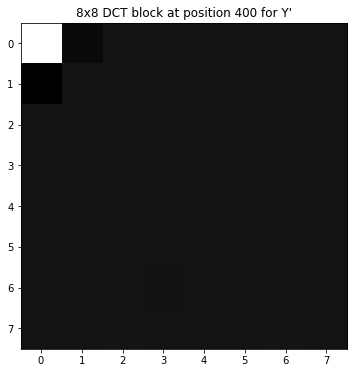

In [21]:
pos = 400 # % int(imsize[0] / BLOCK_SIZE)

plt.figure()
plt.imshow(im[BLOCK(pos, pos, 0)], cmap = 'gray')
plt.title(f'{BLOCK_SIZE}x{BLOCK_SIZE} Image block at position {pos} for Y\'')

plt.figure()
plt.imshow(dct[BLOCK(pos, pos, 0)], cmap = 'gray')
plt.title(f'{BLOCK_SIZE}x{BLOCK_SIZE} DCT block at position {pos} for Y\'')

In [22]:
# Quantize dct coefficients

# JPEG Standard matrix
quantization_matrix = np.array([
	[ 16,  11,  10,  16,  24,  40,  51,  61],
	[ 12,  12,  14,  19,  26,  58,  60,  55],
	[ 14,  13,  16,  24,  40,  57,  69,  56],
	[ 14,  17,  22,  29,  51,  87,  80,  62],
	[ 18,  22,  37,  56,  68, 109, 103,  77],
	[ 24,  35,  55,  64,  81, 104, 113,  92],
	[ 49,  64,  78,  87, 103, 121, 120, 101],
	[ 72,  92,  95,  98, 112, 100, 103,  99]
])

dct_q = np.zeros(imsize, dtype = int)

# Apply 8x8 block quantization
for i in np.r_[:imsize[0] : BLOCK_SIZE]:
	for j in np.r_[:imsize[1] : BLOCK_SIZE]:

		div = dct[BLOCK(i, j)] / quantization_matrix[:, :, None]
		dct_q[BLOCK(i, j)] = np.around(div, 0).astype(int)

print(f'Max Coefficient: {np.max(dct_q)}')
print(f'Mean Coefficient: {np.mean(dct_q)}')
print(f'Min Coefficient: {np.min(dct_q)}')

nonzeros = np.count_nonzero(dct_q)
nonzeros_og = np.count_nonzero(dct)

dim = np.prod(imsize)
compression_ratio = nonzeros_og / nonzeros

print(f'\nTotal Coefficients: {dim}')
print(f'Initially Nonzero : {nonzeros_og}')
print(f'*Quantized Nonzero: {nonzeros}')

print(f'\nCompression ratio: ~{round(compression_ratio, 3)}x')
print(f'Resulting size: ~{round((1 / compression_ratio) * 100, 3)}%')

Max Coefficient: 63
Mean Coefficient: 0.20812278509888804
Min Coefficient: -47

Total Coefficients: 3015936
Initially Nonzero : 448854
*Quantized Nonzero: 89737

Compression ratio: ~5.002x
Resulting size: ~19.992%


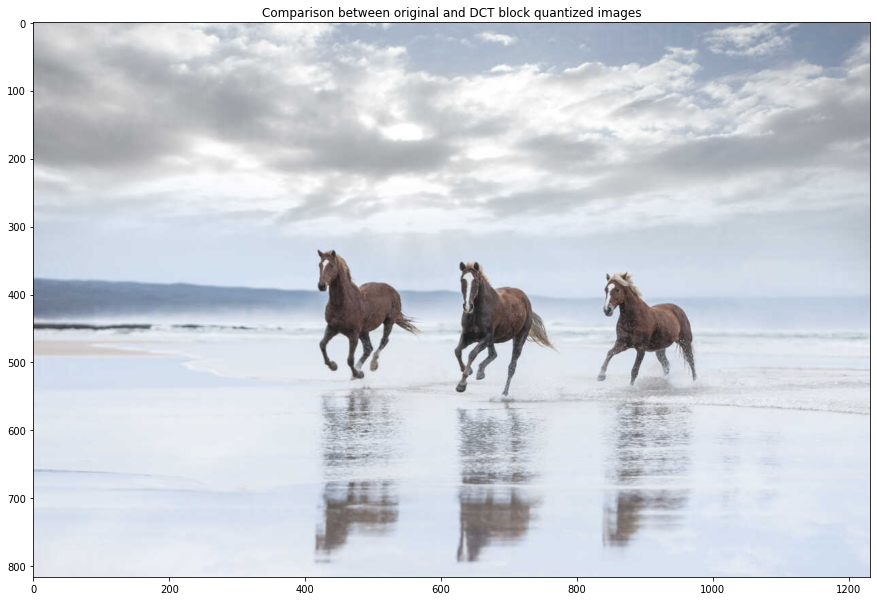

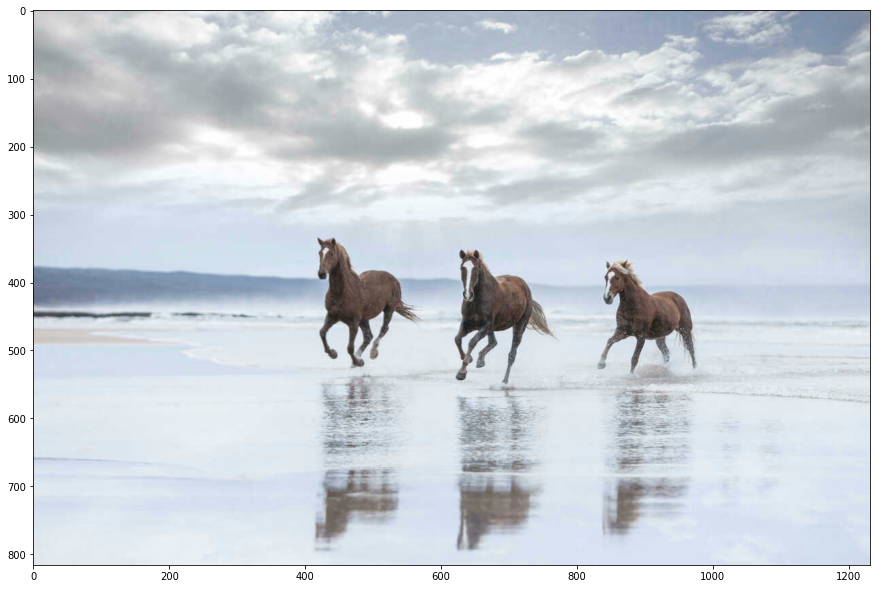

In [26]:

re_dct = np.zeros(imsize)

# Reverse DCT on blocks
for i in np.r_[:imsize[0] : BLOCK_SIZE]:
	for j in np.r_[:imsize[1] : BLOCK_SIZE]:

		reconstruct = dct_q[BLOCK(i, j)] * quantization_matrix[:, :, None]
		inverse = IDCT_2D(reconstruct)
		rounded = np.around(inverse, 0).astype(int)
		added = np.clip(rounded + 128, 0, 255)

		re_dct[BLOCK(i, j)] = added

# Deleting initially padded border
shaped = np.resize(re_dct, im.shape)

# Convert back to RGB color space
final = ycbcr2rgb(shaped)
# final = cv2.cvtColor(np.float32(shaped), cv2.COLOR_YCR_CB2RGB)

plt.figure(figsize = (15, 15))
# plt.imshow(image)
plt.imshow(np.hstack((image, final)))
plt.title('Comparison between original and DCT block quantized images')
plt.figure(figsize = (15, 15))
plt.imshow(final)

In [25]:
def MSE(A, B):
	deviation = A - B
	square = np.square(deviation)
	mse = np.mean(square)
	return mse

def RMSE(A, B):
	deviation = A - B
	square = np.square(deviation)
	mean = np.mean(square)
	rmse = np.sqrt(mean)
	return rmse

def PSNR(MSE):
	A = 20 * np.log10(255)
	B = 10 * np.log10(MSE)
	return A - B

mse = MSE(im, final)
print(f'Mean-Squared Error: {mse} (RMSE: ~{round(np.sqrt(mse), 6)})')
print(f'(Smaller means better reconstruction quality)')

psnr = PSNR(mse)
print(f'\nPeak Signal-to-Noise Ratio: {psnr}')
print(f'(Bigger means better reconstruction quality)')

print(f'\nCompression Ratio: {compression_ratio}')
print(f'(Bigger means more thoroughly compressed image)')

Mean-Squared Error: 96.59825739007724 (RMSE: ~9.828441)
(Smaller means better reconstruction quality)

Peak Signal-to-Noise Ratio: 28.28111068952415
(Bigger means better reconstruction quality)

Compression Ratio: 5.001883281143787
(Bigger means more thoroughly compressed image)
